In [1]:
import os
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

from torch.utils.data import DataLoader
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import json
import time

In [2]:
ROOT_DIR = './dataset/'
data_path = 'AAPL_reduced_no_date.csv'
target_column = 'close'

# Note to check
#freq

In [10]:
# p = pd.read_csv("./dataset/AAPL_reduced.csv")
# p = p.drop(columns=["date"])
# p.to_csv("./dataset/AAPL_reduced_no_date.csv", index=False)
p = pd.read_csv("./dataset/AAPL_reduced_no_date.csv")
p

,open,high,low,close,volume
0,0.796,0.798,0.795,0.797,3662400
1,0.797,0.801,0.795,0.796,1456000
2,0.796,0.800,0.795,0.798,4020800
3,0.797,0.800,0.793,0.797,4065600
4,0.797,0.799,0.792,0.793,8870400
...,...,...,...,...,...
9995,0.846,0.851,0.845,0.847,694400
9996,0.847,0.849,0.844,0.847,683200
9997,0.846,0.848,0.844,0.846,851200
9998,0.844,0.847,0.843,0.845,985600


In [14]:
p['time_id'] = range(0, p.shape[0])
p

,open,high,low,close,volume,time_id
0,0.796,0.798,0.795,0.797,3662400,0
1,0.797,0.801,0.795,0.796,1456000,1
2,0.796,0.800,0.795,0.798,4020800,2
3,0.797,0.800,0.793,0.797,4065600,3
4,0.797,0.799,0.792,0.793,8870400,4
...,...,...,...,...,...,...
9995,0.846,0.851,0.845,0.847,694400,9995
9996,0.847,0.849,0.844,0.847,683200,9996
9997,0.846,0.848,0.844,0.846,851200,9997
9998,0.844,0.847,0.843,0.845,985600,9998


In [15]:
p.to_csv("./dataset/AAPL_reduced_time_id.csv", index=False)

In [4]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path =  ROOT_DIR#'/content/' # root path of data file
args.data_path = data_path#'output.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS];
                    #M:multivariate predict multivariate, S:univariate predict univariate,
                    #MS:multivariate predict univariate
args.target = target_column # target feature in S or MS task
args.freq = '1m' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 84 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 8 # encoder input size
args.dec_in = 8 # decoder input size
args.c_out = 8 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 2
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [5]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [6]:
args.data

'custom'

In [7]:
# Set augments by using data name
data_parser = {
    'custom':{'data':data_path,'T':target_column,'M':[6,6,6],'S':[1,1,1],'MS':[5,5,1]}, #Change the array here based on the number of features
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

args.detail_freq = args.freq
args.freq = args.freq[-1:]

Exp = Exp_Informer
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': './dataset/', 'data_path': 'AAPL_reduced_no_date.csv', 'features': 'MS', 'target': 'close', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 84, 'enc_in': 5, 'dec_in': 5, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 2, 'patience': 3, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [8]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

using mps device
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>


KeyError: "['date'] not in index"

In [ ]:
# set saved model path
setting = 'informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')


# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

exp.predict(setting, True)

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

len(data_set), len(data_loader)

using mps device
pred 1


(1, 1)

In [ ]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((1888, 84, 1), (1888, 84, 1))

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(trues, preds, start_index, step, num_plots):
    num_rows = num_plots // 3
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 3 * num_rows), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < num_plots:
            index = start_index + i * step

            ax.plot(trues[index, :, -1], label='GroundTruth')
            ax.plot(preds[index, :, -1], label='Prediction')

            ax.set_title(f'Index {index}')
            ax.legend()
            ax.set_xlabel('time (h)')
            ax.set_ylabel('Close Price')
            ax.tick_params(axis='both', which='both', labelsize=8, direction='in')

        else:
            ax.axis('off')


    plt.tight_layout()
    plt.show()

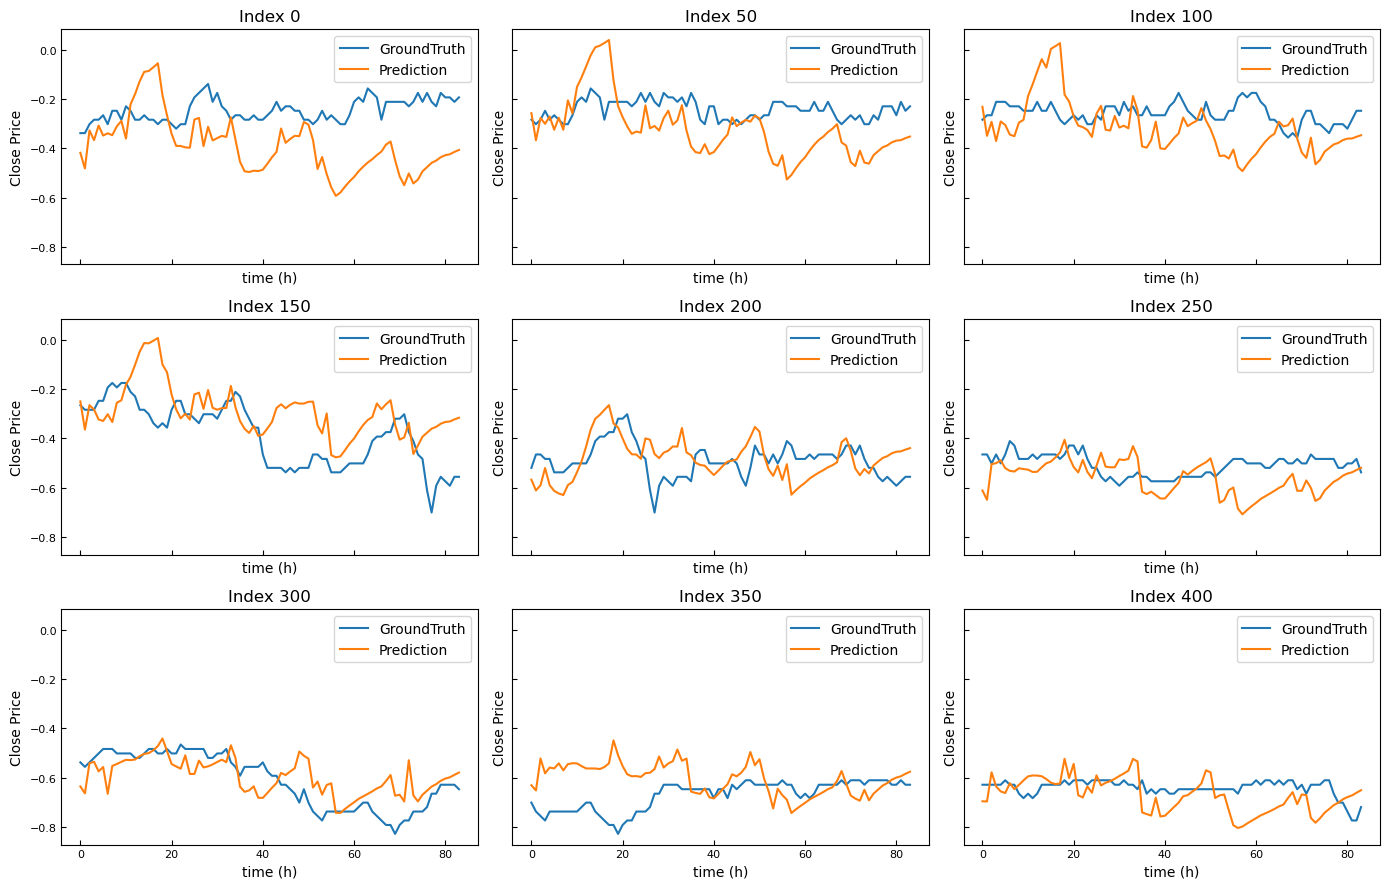

In [ ]:
plot_predictions(trues, preds, start_index=0, step=50, num_plots=9)

In [14]:
import glob
import os
import operator

search_dir = "./informer_checkpoints/"
dirs = os.listdir(search_dir)
dir_list = []
for d in dirs:
    date_change = os.path.getmtime(search_dir + d)
    dir_list.append({'directory_name': d, 'changed_date': date_change})

sorted(dir_list, key=lambda x: x['changed_date'], reverse=True)[0]['directory_name']


'informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0'